# Initialize

In [1]:
#  Python Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
# import requests
import json
import math
import itertools
from cycler import cycler
import plotly

import imp

# Custom Modules
import CensusData
import CovidData
import CovidFunctions
import CovidFunctionsPlotly

# imp.reload(CovidData)

# Covid Data    
https://covidtracking.com/api  
https://github.com/nytimes/covid-19-data

## Download and Import Data

In [2]:
# Census Data
dfStateData = CensusData.StateData()

# Covid Data
dfCovid = CovidData.combine_data()

# State Level Events
dfEvents = pd.read_csv('Events.txt',parse_dates=[1])

# CDC Death Data
dfCDCdeaths = CovidData.cdc_death_data(dfStateData)

https://api.census.gov/data/2019/pep/population?get=POP&for=state:*
Population data API call result: 200 OK
https://api.census.gov/data/2010/dec/sf1?get=NAME&for=state:*
State name API call result: 200 OK
https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv
https://covidtracking.com/api/v1/states/daily.csv
Starting download CDC weekely death data...
Downloaded CDC weekly death data for every state from 2014-present.


# Data Analysis

## Merge Data

In [3]:
col = dfCovid.loc[: , ["cases(NYT)","positive(CTP)"]]
dfCovid['positive_cases'] = col.mean(axis=1)

col = dfCovid.loc[: , ["deaths(NYT)","death(CTP)"]]
dfCovid['deaths'] = col.mean(axis=1)

print(dfCovid.columns.values)

['cases(NYT)' 'deaths(NYT)' 'positive(CTP)' 'negative(CTP)' 'pending(CTP)'
 'hospitalizedCurrently(CTP)' 'hospitalizedCumulative(CTP)'
 'inIcuCurrently(CTP)' 'inIcuCumulative(CTP)' 'onVentilatorCurrently(CTP)'
 'onVentilatorCumulative(CTP)' 'recovered(CTP)' 'dateChecked(CTP)'
 'death(CTP)' 'hospitalized(CTP)' 'totalTestResults(CTP)'
 'deathIncrease(CTP)' 'hospitalizedIncrease(CTP)' 'negativeIncrease(CTP)'
 'positiveIncrease(CTP)' 'totalTestResultsIncrease(CTP)' 'positive_cases'
 'deaths']


## Deaths correlated to cases from previous days

In [4]:
shiftSearch = 30
fipsList = dfCovid.index.get_level_values(0).unique().astype(int).sort_values().astype(str)

dfShiftCor = CovidFunctions.correlations(shiftSearch, dfCovid, fipsList)

C:\Users\Scott\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning:

divide by zero encountered in log



Completed 30 days of case-death correlations and auto-correlations.


## State level analysis

In [5]:
firstDate = dfCovid.index.get_level_values(1).min()
currentDate = dfCovid.index.get_level_values(1).max()
plotDateRange = [firstDate, currentDate]    

In [ ]:
imp.reload(CovidFunctions)
imp.reload(CovidFunctionsPlotly)

# Create plots for each state
for fips in fipsList:
    if int(fips) in [int(i) for i in dfStateData.index.tolist()]:
        CovidFunctions.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, fips, plotDateRange)
        plt.close()
        CovidFunctionsPlotly.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, dfCDCdeaths, fips, plotDateRange)
    else:
        print('Did not create plot for FIPS = ' + fips)
        
# Update index.md
CovidFunctionsPlotly.githubIndex(dfStateData, fipsList)
        
print('Finished Creating all State plots')

C:\Users\Scott\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



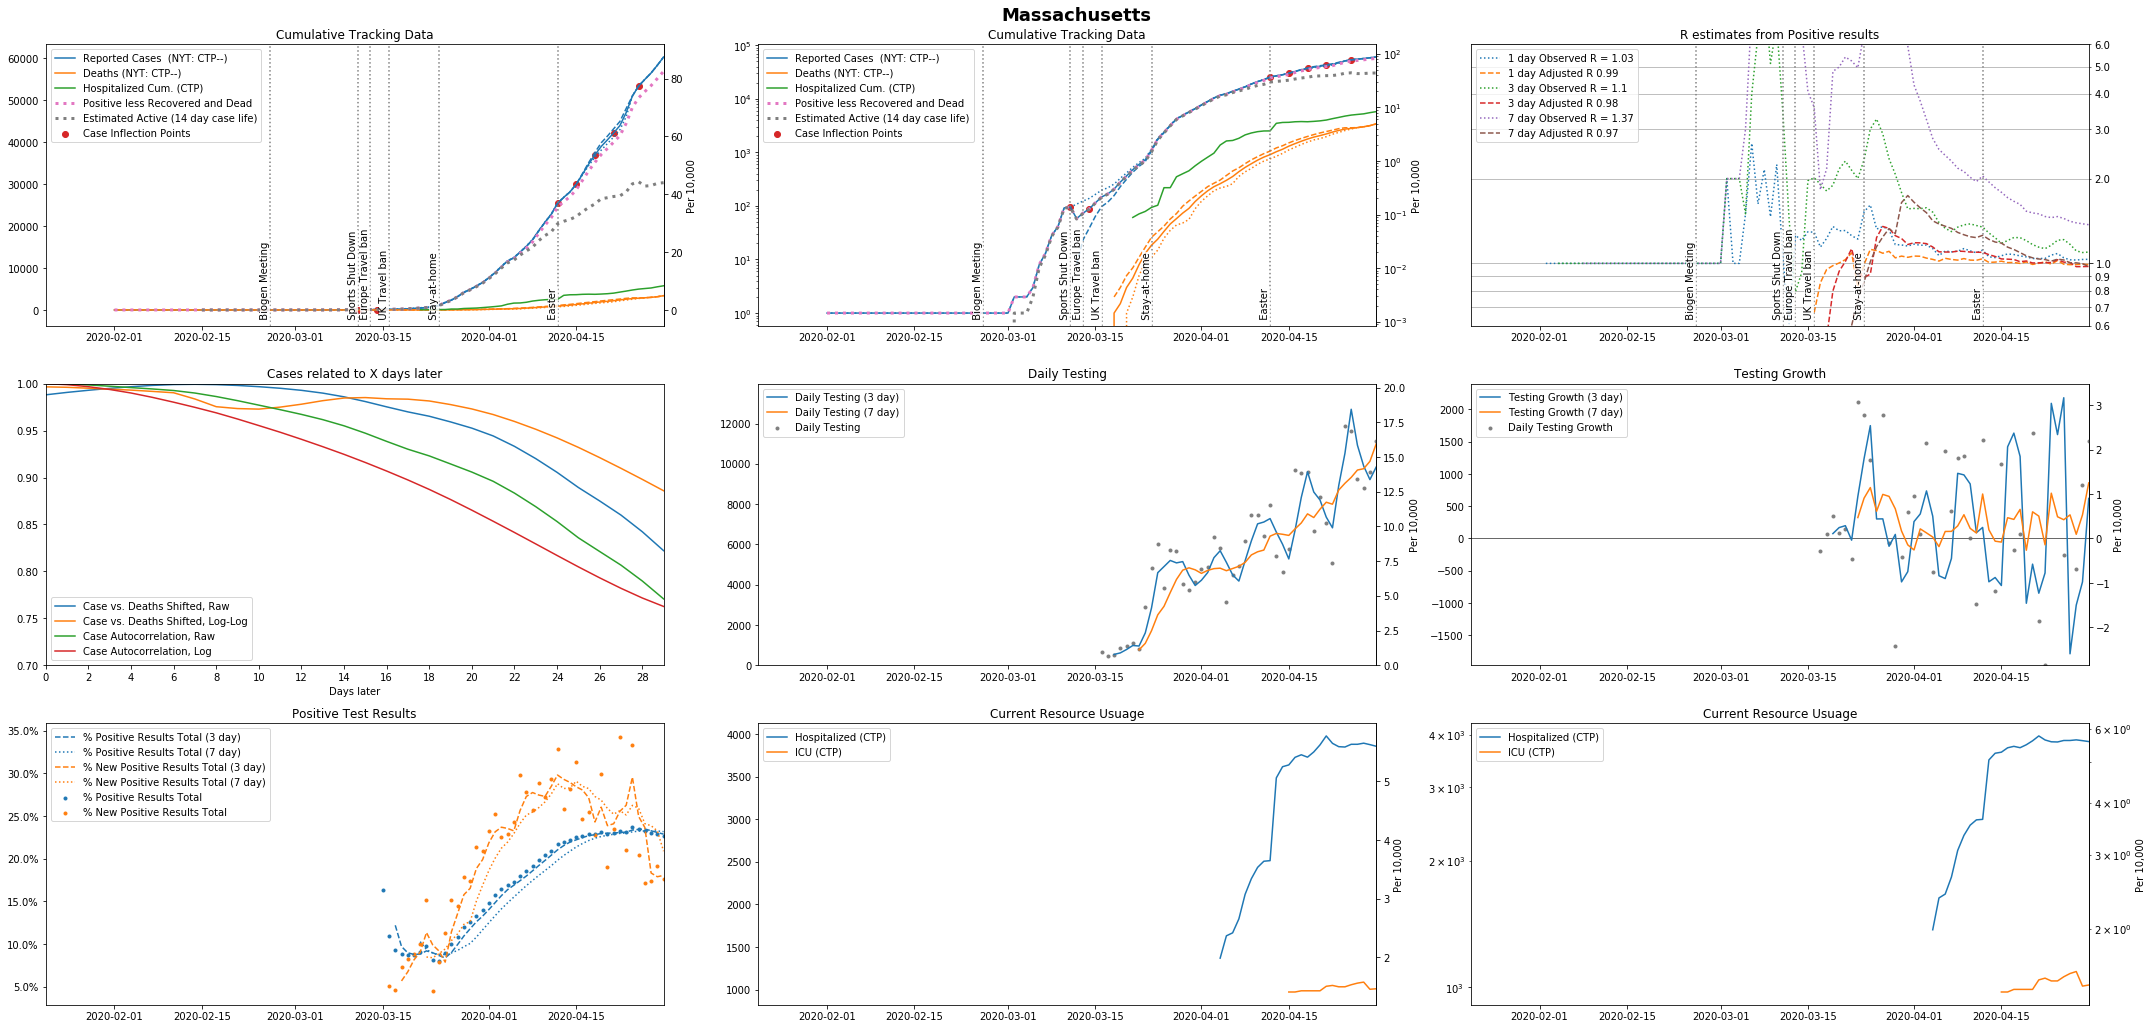

In [8]:
imp.reload(CovidFunctions)

fips = '25'
# plt.plot(dfCovid.loc[fips]['positive_cases'])

CovidFunctions.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, fips, plotDateRange)


In [13]:
imp.reload(CovidFunctionsPlotly)
fips = '25'

CovidFunctionsPlotly.state_plot(dfCovid, dfShiftCor, dfStateData, dfEvents, dfCDCdeaths, fips, plotDateRange)

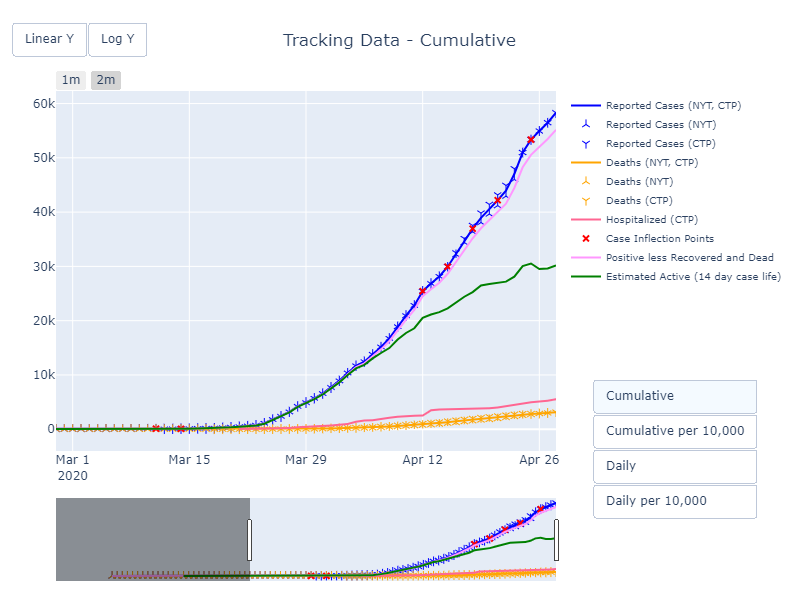

In [239]:
imp.reload(CovidFunctionsPlotly)
fips = '25'
fig = CovidFunctionsPlotly.tracking_plot(dfCovid, fips, plotDateRange, dfStateData)
# fig = CovidFunctionsPlotly.event_markers(fig, dfEventsState)

fig.show()


In [12]:
# Update index.md
imp.reload(CovidFunctionsPlotly)
CovidFunctionsPlotly.githubIndex(dfStateData, fipsList)

In [252]:
filename = 'figs/Tracking Data District of Columbia.html'

print()

headerText = filename.split('/')[1].split('.')[0]

print(headerText)

space = ' '
stateName = space.join(headerText.split(' ')[2:])

print(stateName)


Tracking Data District of Columbia
District of Columbia
